# Project 2: HDB price predictor for young families
### Kaggle submission

# Cleaning
---
Reading in the test dataset

In [49]:
# Importing libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as metrics
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
import scipy.stats as stats

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from datetime import datetime
from scipy.spatial.distance import cdist
from fuzzywuzzy import process


In [50]:
hdb_test = pd.read_csv('../datasets/test.csv')

/var/folders/8t/r_dj4lrd7vg_k505mk7n7lv00000gn/T/ipykernel_23240/3213883354.py:1: DtypeWarning: Columns (41) have mixed types. Specify dtype option on import or set low_memory=False.
  hdb_test = pd.read_csv('../datasets/test.csv')


In [51]:
hdb_test.head()

,id,Tranc_YearMonth,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,...,vacancy,pri_sch_affiliation,pri_sch_latitude,pri_sch_longitude,sec_sch_nearest_dist,sec_sch_name,cutoff_point,affiliation,sec_sch_latitude,sec_sch_longitude
0,114982,2012-11,YISHUN,4 ROOM,173,YISHUN AVE 7,07 TO 09,84.0,Simplified,1987,...,92,0,1.433681,103.832924,156.322353,Ahmad Ibrahim Secondary School,218,0,1.436235,103.829987
1,95653,2019-08,JURONG WEST,5 ROOM,986C,JURONG WEST ST 93,04 TO 06,112.0,Premium Apartment,2008,...,45,0,1.339244,103.698896,739.371688,Jurong West Secondary School,199,0,1.335256,103.702098
2,40303,2013-10,ANG MO KIO,3 ROOM,534,ANG MO KIO AVE 10,07 TO 09,68.0,New Generation,1980,...,36,0,1.371893,103.851811,305.071191,Anderson Secondary School,245,0,1.374242,103.851430
3,109506,2017-10,WOODLANDS,4 ROOM,29,MARSILING DR,01 TO 03,97.0,New Generation,1979,...,54,0,1.434423,103.773698,433.454591,Woodlands Secondary School,188,0,1.439183,103.774499
4,100149,2016-08,BUKIT BATOK,4 ROOM,170,BT BATOK WEST AVE 8,16 TO 18,103.0,Model A,1985,...,40,0,1.349195,103.741000,217.295361,Bukit Batok Secondary School,223,0,1.348351,103.740873


In [52]:
hdb_test.describe()

,id,floor_area_sqm,lease_commence_date,Tranc_Year,Tranc_Month,mid_storey,lower,upper,mid,floor_area_sqft,...,pri_sch_nearest_distance,vacancy,pri_sch_affiliation,pri_sch_latitude,pri_sch_longitude,sec_sch_nearest_dist,cutoff_point,affiliation,sec_sch_latitude,sec_sch_longitude
count,16737.000000,16737.000000,16737.000000,16737.000000,16737.000000,16737.000000,16737.000000,16737.000000,16737.000000,16737.000000,...,16737.000000,16737.000000,16737.000000,16737.000000,16737.000000,16737.000000,16737.000000,16737.000000,16737.000000,16737.000000
mean,92253.767342,96.923821,1992.341220,2016.462568,6.571309,8.276394,7.237737,9.315050,8.276394,1043.288014,...,395.119993,55.359204,0.112625,1.366010,103.839511,510.960150,210.146681,0.033698,1.365737,103.839711
std,53302.038393,24.447727,12.170893,2.745399,3.338882,5.503939,5.512181,5.502442,5.503939,263.155328,...,234.336770,17.892749,0.316143,0.042559,0.072244,312.758000,20.050729,0.180456,0.042529,0.072266
min,7.000000,31.000000,1966.000000,2012.000000,1.000000,2.000000,1.000000,3.000000,2.000000,333.684000,...,45.668324,20.000000,0.000000,1.274962,103.687724,45.429070,188.000000,0.000000,1.276029,103.687207
25%,46550.000000,74.000000,1984.000000,2014.000000,4.000000,5.000000,4.000000,6.000000,5.000000,796.536000,...,227.739700,44.000000,0.000000,1.337289,103.773754,292.017769,188.000000,0.000000,1.337545,103.776008
50%,91830.000000,95.000000,1991.000000,2017.000000,7.000000,8.000000,7.000000,9.000000,8.000000,1022.580000,...,347.207319,54.000000,0.000000,1.364639,103.844934,448.018148,208.000000,0.000000,1.366132,103.842719
75%,137789.000000,112.000000,2001.000000,2019.000000,9.000000,11.000000,10.000000,12.000000,11.000000,1205.568000,...,501.045376,67.000000,0.000000,1.393574,103.898773,644.284099,224.000000,0.000000,1.391781,103.899872
max,185967.000000,266.000000,2019.000000,2021.000000,12.000000,50.000000,49.000000,51.000000,50.000000,2863.224000,...,3305.841039,110.000000,1.000000,1.456667,103.962919,3636.953504,260.000000,1.000000,1.453280,103.961105


In [53]:
hdb_test.shape

(16737, 77)

In [54]:
hdb_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16737 entries, 0 to 16736
Data columns (total 77 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         16737 non-null  int64  
 1   Tranc_YearMonth            16737 non-null  object 
 2   town                       16737 non-null  object 
 3   flat_type                  16737 non-null  object 
 4   block                      16737 non-null  object 
 5   street_name                16737 non-null  object 
 6   storey_range               16737 non-null  object 
 7   floor_area_sqm             16737 non-null  float64
 8   flat_model                 16737 non-null  object 
 9   lease_commence_date        16737 non-null  int64  
 10  Tranc_Year                 16737 non-null  int64  
 11  Tranc_Month                16737 non-null  int64  
 12  mid_storey                 16737 non-null  int64  
 13  lower                      16737 non-null  int

In [55]:
missing_values = hdb_test.isnull()

missing_count = hdb_test.isnull().sum()

any_missing = hdb_test.isnull().any().any()

missing_percentage = hdb_test.isnull().mean() * 100
print(missing_percentage)

id                   0.0
Tranc_YearMonth      0.0
town                 0.0
flat_type            0.0
block                0.0
                    ... 
sec_sch_name         0.0
cutoff_point         0.0
affiliation          0.0
sec_sch_latitude     0.0
sec_sch_longitude    0.0
Length: 77, dtype: float64


In [56]:
# Saving the dataframe separately to be used later
hdb_test_save = hdb_test

In [57]:
# Mirroring the features selected based on the train set
hdb_test = hdb_test[['Tranc_YearMonth', 'town','floor_area_sqm', 'mid_storey', 'flat_type', 'hdb_age', 'Latitude', 'Longitude', 'Mall_Nearest_Distance', 'Hawker_Nearest_Distance', 'mrt_nearest_distance', 'bus_interchange', 'bus_stop_nearest_distance', 'pri_sch_name', 'pri_sch_latitude', 'pri_sch_longitude']]


In [58]:
hdb_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16737 entries, 0 to 16736
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Tranc_YearMonth            16737 non-null  object 
 1   town                       16737 non-null  object 
 2   floor_area_sqm             16737 non-null  float64
 3   mid_storey                 16737 non-null  int64  
 4   flat_type                  16737 non-null  object 
 5   hdb_age                    16737 non-null  int64  
 6   Latitude                   16737 non-null  float64
 7   Longitude                  16737 non-null  float64
 8   Mall_Nearest_Distance      16653 non-null  float64
 9   Hawker_Nearest_Distance    16737 non-null  float64
 10  mrt_nearest_distance       16737 non-null  float64
 11  bus_interchange            16737 non-null  int64  
 12  bus_stop_nearest_distance  16737 non-null  float64
 13  pri_sch_name               16737 non-null  obj

In [59]:
# Convert all column names to lower case to maintain consistency with previous steps
hdb_test.columns = hdb_test.columns.str.lower()

In [60]:
# Renaming columns
hdb_test = hdb_test.rename(columns={'tranc_yearmonth': 'transact_date',
                                    'mid_storey': 'storey',
                                    'hdb_age': 'age',
                                    'latitude': 'lat',
                                    'longitude': 'lon',
                                    'mall_nearest_distance': 'mall_dist',
                                    'hawker_nearest_distance': 'hawker_dist',
                                    'mrt_nearest_distance': 'mrt_dist',
                                    'bus_stop_nearest_distance': 'bus_stop_dist',
                                    'pri_sch_name': 'pri_sch',
                                    'pri_sch_latitude': 'pri_sch_lat',
                                    'pri_sch_longitude': 'pri_sch_lon'})

In [61]:
# Converting the transaction date column into an integer so that correlation can be plotted

hdb_test['transact_date'] = hdb_test['transact_date'].str.replace('-', '')
hdb_test['transact_date'] = hdb_test['transact_date'].astype(int)
hdb_test['transact_date'].dtypes

dtype('int64')

In [62]:
# Finding out the date range of this final data set

print(f"Earliest transaction date within this data set is {hdb_test['transact_date'].min()}")
print(f"Latest transaction date within this data set is {hdb_test['transact_date'].max()}")

Earliest transaction date within this data set is 201203
Latest transaction date within this data set is 202104


### Dealing with null values in the mall distance feature

In [63]:
hdb_test[hdb_test['mall_dist'].isnull()].head(10)

,transact_date,town,floor_area_sqm,storey,flat_type,age,lat,lon,mall_dist,hawker_dist,mrt_dist,bus_interchange,bus_stop_dist,pri_sch,pri_sch_lat,pri_sch_lon
441,202101,PUNGGOL,113.0,5,5 ROOM,5,1.405880,103.910159,NaN,4569.150769,840.070191,1,154.258519,Oasis Primary School,1.404409,103.910996
481,202102,WOODLANDS,93.0,5,4 ROOM,4,1.437562,103.793320,NaN,872.238804,679.546898,1,114.643278,Woodlands Primary School,1.436746,103.791772
579,202104,BEDOK,68.0,8,3 ROOM,5,1.327893,103.923875,NaN,474.617573,758.954447,1,121.835193,Damai Primary School,1.335351,103.921268
661,202101,TAMPINES,94.0,8,4 ROOM,4,1.356087,103.931752,NaN,1004.072772,1363.523236,0,101.686748,Poi Ching School,1.358087,103.935352
782,202101,QUEENSTOWN,83.0,32,4 ROOM,5,1.295794,103.809265,NaN,753.568384,383.530942,0,193.064957,Queenstown Primary School,1.295988,103.807902
1127,202104,BEDOK,93.0,11,4 ROOM,5,1.327893,103.923875,NaN,474.617573,758.954447,1,121.835193,Damai Primary School,1.335351,103.921268
1278,202102,PUNGGOL,93.0,11,4 ROOM,5,1.405402,103.895910,NaN,3664.509911,748.150129,1,140.899897,Valour Primary School,1.406871,103.898911
1632,202104,CHOA CHU KANG,93.0,5,4 ROOM,4,1.373819,103.743367,NaN,3271.762635,1325.538517,1,93.652239,Chua Chu Kang Primary School,1.377743,103.741861
1705,202011,SENGKANG,93.0,11,4 ROOM,5,1.398071,103.877933,NaN,2618.117577,2075.574992,1,71.790479,Fern Green Primary School,1.397621,103.880210
1968,202104,CHOA CHU KANG,113.0,8,5 ROOM,4,1.373387,103.744026,NaN,3206.986619,1370.450299,1,148.373849,Chua Chu Kang Primary School,1.377743,103.741861


In [64]:
from geopy.distance import geodesic

# Step 1: Identify rows with null 'mall_dist'
null_mall_dist = hdb_test[hdb_test['mall_dist'].isnull()]

# Step 2: Iterate over rows with null 'mall_dist'
for index, row in null_mall_dist.iterrows():
    min_dist = float('inf')
    nearest_mall_dist = None
    
    # Step 3: Calculate distance to each row with non-null 'mall_dist'
    for idx, r in hdb_test[hdb_test['mall_dist'].notnull()].iterrows():
        dist = geodesic((row['lat'], row['lon']), (r['lat'], r['lon'])).km
        
        # Step 4: Identify row with minimum distance
        if dist < min_dist:
            min_dist = dist
            nearest_mall_dist = r['mall_dist']
    
    # Step 5: Fill null value with nearest 'mall_dist'
    hdb_test.at[index, 'mall_dist'] = nearest_mall_dist

In [65]:
hdb_test.isnull().sum()

transact_date      0
town               0
floor_area_sqm     0
storey             0
flat_type          0
age                0
lat                0
lon                0
mall_dist          0
hawker_dist        0
mrt_dist           0
bus_interchange    0
bus_stop_dist      0
pri_sch            0
pri_sch_lat        0
pri_sch_lon        0
dtype: int64

# Feature engineering
---

### 1. Tiering Primary schools

In [66]:
ballot_df = pd.read_csv('../datasets/p1_ballot_2021.csv')
print(ballot_df.head())

            School  Vacancies  Applications
0      *Admiralty*        210           264
1  *Ahmad Ibrahim*        210            84
2        *Ai Tong*        300           364
3      *Alexandra*        200           223
4   *Anchor Green*        240           271


In [67]:
# Clean the school names by removing special characters and trimming spaces
ballot_df['School'] = ballot_df['School'].str.replace(r'[^a-zA-Z0-9\s]', '', regex=True).str.strip()

# Display all the cleaned school names
cleaned_school_names = ballot_df['School'].unique()
cleaned_school_names.sort()  # Sort the names for easier viewing
cleaned_school_names[:5]

array(['Admiralty', 'Ahmad Ibrahim', 'Ai Tong', 'Alexandra',
       'Anchor Green'], dtype=object)

In [68]:
# Calculate the popularity metric as the ratio of Applications to Vacancies
ballot_df['Popularity_Ratio'] = ballot_df['Applications'] / ballot_df['Vacancies']

# Display the dataframe with the new column to verify the calculation
ballot_df.head()

,School,Vacancies,Applications,Popularity_Ratio
0,Admiralty,210,264,1.257143
1,Ahmad Ibrahim,210,84,0.400000
2,Ai Tong,300,364,1.213333
3,Alexandra,200,223,1.115000
4,Anchor Green,240,271,1.129167


In [69]:
# Determine the quantile values for splitting the tiers
quantiles = ballot_df['Popularity_Ratio'].quantile([1/3, 2/3])

# Assign tiers based on quantiles
ballot_df['pri_sch_tier'] = pd.cut(ballot_df['Popularity_Ratio'],
                              bins=[0, quantiles.iloc[0], quantiles.iloc[1], ballot_df['Popularity_Ratio'].max()],
                              labels=['pri_sch_tier_3', 'pri_sch_tier_2', 'pri_sch_tier_1'],
                              include_lowest=True)

# Verify the tier assignments by displaying the first few rows
ballot_df.head()

,School,Vacancies,Applications,Popularity_Ratio,pri_sch_tier
0,Admiralty,210,264,1.257143,pri_sch_tier_1
1,Ahmad Ibrahim,210,84,0.400000,pri_sch_tier_3
2,Ai Tong,300,364,1.213333,pri_sch_tier_1
3,Alexandra,200,223,1.115000,pri_sch_tier_2
4,Anchor Green,240,271,1.129167,pri_sch_tier_2


In [70]:
# Convert all column names to lower case to maintain consistency
ballot_df.columns = ballot_df.columns.str.lower()

ballot_df.head()

,school,vacancies,applications,popularity_ratio,pri_sch_tier
0,Admiralty,210,264,1.257143,pri_sch_tier_1
1,Ahmad Ibrahim,210,84,0.400000,pri_sch_tier_3
2,Ai Tong,300,364,1.213333,pri_sch_tier_1
3,Alexandra,200,223,1.115000,pri_sch_tier_2
4,Anchor Green,240,271,1.129167,pri_sch_tier_2


In [71]:
# Normalize the primary school names in the hdb_test dataset
hdb_test['pri_sch_name'] = hdb_test['pri_sch'].str.replace(r'[^a-zA-Z0-9\s]', '', regex=True).str.strip()

In [72]:
# Define a function to perform fuzzy matching and return the best match and its score
def fuzzy_match_school(x, choices, scorer, cutoff):
    match = process.extractOne(x, choices, scorer=scorer, score_cutoff=cutoff)
    return match if match else (None, None)

# Sample some schools for fuzzy matching demonstration
sample_schools = hdb_test['pri_sch'].sample(n=5, random_state=1).tolist()

# School choices from the original dataset
school_choices = ballot_df['school'].unique()

# Apply fuzzy matching to the sample without specifying a custom scorer
fuzzy_matches = [process.extractOne(school, school_choices, score_cutoff=85) for school in sample_schools]

# Display the sample schools and their fuzzy matches
fuzzy_matches_dict = dict(zip(sample_schools, fuzzy_matches))
fuzzy_matches_dict

{'Jiemin Primary School': ('Jiemin', 90),
 'Damai Primary School': ('Damai', 90),
 'Shuqun Primary School': ('Shuqun', 90),
 'Ahmad Ibrahim Primary School': ('Ahmad Ibrahim', 90),
 'Eunos Primary School': None}

In [73]:
# Prepare lists of unique school names from both datasets for fuzzy matching
unique_new_school_names = hdb_test['pri_sch'].unique()
unique_original_school_names = ballot_df['school'].unique()


# Adjust the fuzzy matching process to properly handle cases where no match meets the score cutoff
match_mapping = {}
for school in unique_new_school_names:
    result = process.extractOne(school, unique_original_school_names, score_cutoff=90)
    if result:
        match, score = result
        match_mapping[school] = match

# Apply the match results to the new dataset
hdb_test['pri_sch_matched'] = hdb_test['pri_sch'].map(match_mapping).fillna(hdb_test['pri_sch'])

# Display the number of matches and some examples for verification
len(match_mapping), list(match_mapping.items())[:5]  # Display the number of matches and a few examples


(163,
 [('Ahmad Ibrahim Primary School', 'Ahmad Ibrahim'),
  ('Jurong West Primary School', 'Jurong'),
  ('Jing Shan Primary School', 'Jing Shan'),
  ('Marsiling Primary School', 'Marsiling'),
  ('Princess Elizabeth Primary School', 'Princess Elizabeth')])

In [74]:
# Apply fuzzy matching to all school names in the new dataset with a score cutoff to filter for scores less than 90
all_school_matches = {school: process.extractOne(school, school_choices, score_cutoff=0) for school in hdb_test['pri_sch'].unique()}

# Filter matches to only include those with scores less than 90
matches_less_than_90 = {school: match for school, match in all_school_matches.items() if match and match[1] < 90}

matches_less_than_90

{"Saint Anthony's Primary School": ('AngloChinese Primary', 86),
 "Saint Hilda's Primary School": ('St Hildas', 80),
 "Saint Andrew's Junior School": ('Montfort Junior', 86),
 "Saint Anthony's Canossian Primary School": ('AngloChinese Primary', 86),
 'Juying Primary School': ('Jurong', 60),
 'Pioneer Primary School': ('AngloChinese Primary', 57),
 'Eunos Primary School': ('AngloChinese Primary', 57),
 'Guangyang Primary School': ('Nanyang', 77),
 'Stamford Primary School': ('Pasir Ris', 50),
 "CHIJ Saint Nicholas Girls' School": ('CHIJ Katong', 86),
 "Saint Margaret's Primary School": ('AngloChinese Primary', 86),
 'CHIJ Primary': ('AngloChinese Primary', 86),
 "Saint Stephen's School": ('St Stephens', 82)}

In [75]:
# Correction mapping

correction_mapping = {
    "Saint Margarets Primary School": "St Margarets",
    "Saint Andrews Junior School": "St Andrews Junior",
    "CHIJ Saint Nicholas Girls School": "CHIJ St Nicholas Girls",
    "Saint Anthonys Canossian Primary School": "St Anthonys Canossian",
    "Saint Hilda's Primary School": "St Hildas"
}

In [76]:
# Applying corrections to the 'pri_sch' column
hdb_test['pri_sch'] = hdb_test['pri_sch'].apply(lambda x: correction_mapping.get(x, x))
hdb_test.head()

,transact_date,town,floor_area_sqm,storey,flat_type,age,lat,lon,mall_dist,hawker_dist,mrt_dist,bus_interchange,bus_stop_dist,pri_sch,pri_sch_lat,pri_sch_lon,pri_sch_name,pri_sch_matched
0,201211,YISHUN,84.0,8,4 ROOM,34,1.437066,103.831121,877.431572,687.576779,686.660434,0,75.683952,Ahmad Ibrahim Primary School,1.433681,103.832924,Ahmad Ibrahim Primary School,Ahmad Ibrahim
1,201908,JURONG WEST,112.0,5,5 ROOM,13,1.336957,103.695668,534.037705,2122.346226,169.478175,0,88.993058,Jurong West Primary School,1.339244,103.698896,Jurong West Primary School,Jurong
2,201310,ANG MO KIO,68.0,8,3 ROOM,41,1.374058,103.854168,817.050453,152.287621,694.220448,1,86.303575,Jing Shan Primary School,1.371893,103.851811,Jing Shan Primary School,Jing Shan
3,201710,WOODLANDS,97.0,2,4 ROOM,42,1.442748,103.772922,1272.737194,501.892158,1117.203587,0,108.459039,Marsiling Primary School,1.434423,103.773698,Marsiling Primary School,Marsiling
4,201608,BUKIT BATOK,103.0,17,4 ROOM,36,1.346556,103.740101,1070.963675,437.593564,987.976010,0,113.645431,Princess Elizabeth Primary School,1.349195,103.741000,Princess Elizabeth Primary School,Princess Elizabeth


In [77]:
# Merge the tier information from the original dataset into the new dataset based on the matched school names
hdb_test = pd.merge(hdb_test, ballot_df[['school', 'pri_sch_tier']], left_on='pri_sch_matched', right_on='school', how='left')

# Display a few rows of the merged dataset to verify the tier information has been correctly merged
hdb_test[['pri_sch', 'pri_sch_matched', 'school', 'pri_sch_tier']].sample(10)

,pri_sch,pri_sch_matched,school,pri_sch_tier
16105,Red Swastika School,Red Swastika,Red Swastika,pri_sch_tier_1
10481,Canberra Primary School,Canberra,Canberra,pri_sch_tier_2
13275,Blangah Rise Primary School,Blangah Rise,Blangah Rise,pri_sch_tier_3
984,Mayflower Primary School,Mayflower,Mayflower,pri_sch_tier_3
411,Fernvale Primary School,Fernvale,Fernvale,pri_sch_tier_3
13787,Bedok Green Primary School,Bedok Green,Bedok Green,pri_sch_tier_3
3151,East Spring Primary School,East Spring,East Spring,pri_sch_tier_3
15302,Stamford Primary School,Stamford Primary School,NaN,NaN
10328,Keming Primary School,Keming,Keming,pri_sch_tier_1
961,Unity Primary School,Unity,Unity,pri_sch_tier_3


In [78]:
# Count the null values in the 'pri_sch_tier' column before dropping NaN values
null_tier_count = hdb_test['pri_sch_tier'].isnull().sum()

null_tier_count

950

950 entries where nearest primary schools are not tiered. These may be schools that are 
1. not accounted for in the ballot data (e.g. the school does not want to share ballot data) 
2. have since been not in operation from 2021

These non-tiered schools will be treated as tier 3 schools to generate the model

In [79]:
hdb_test['pri_sch_tier'].unique()

['pri_sch_tier_3', 'pri_sch_tier_2', 'pri_sch_tier_1', NaN]
Categories (3, object): ['pri_sch_tier_3' < 'pri_sch_tier_2' < 'pri_sch_tier_1']

In [80]:
# Converting non-tiered schools to tier 3

hdb_test['pri_sch_tier'].fillna('pri_sch_tier_3', inplace=True)
hdb_test['pri_sch_tier'].unique()

['pri_sch_tier_3', 'pri_sch_tier_2', 'pri_sch_tier_1']
Categories (3, object): ['pri_sch_tier_3' < 'pri_sch_tier_2' < 'pri_sch_tier_1']

In [81]:
# Perform one-hot encoding on the 'pri_sch_tier' column, dropping the first category to avoid multicollinearity
pri_sch_tier_one_hot = pd.get_dummies(hdb_test['pri_sch_tier'], drop_first=True)

# Join the one-hot encoded pri_sch_tiers back to the cleaned dataset
hdb_test = hdb_test.join(pri_sch_tier_one_hot, lsuffix='_clean', rsuffix='_one_hot')

In [82]:
# Display a few rows of the final dataset to verify the one-hot encoding
hdb_test[['pri_sch', 'pri_sch_lat', 'pri_sch_lon', 'pri_sch_name', 'pri_sch_matched', 'school', 'pri_sch_tier', 'pri_sch_tier_2', 'pri_sch_tier_1']].head()

# Drop the specified columns from the merged data
hdb_test = hdb_test.drop(columns=['pri_sch_name', 'pri_sch_matched', 'school', 'pri_sch_tier'])

# Display a few rows of the dataset after dropping the specified columns to verify
hdb_test.sample(10)

,transact_date,town,floor_area_sqm,storey,flat_type,age,lat,lon,mall_dist,hawker_dist,mrt_dist,bus_interchange,bus_stop_dist,pri_sch,pri_sch_lat,pri_sch_lon,pri_sch_tier_2,pri_sch_tier_1
10621,201809,YISHUN,104.0,8,4 ROOM,36,1.426536,103.830669,667.352235,635.833613,558.064085,1,154.590187,Jiemin Primary School,1.427647,103.830480,False,False
11300,201812,YISHUN,104.0,11,4 ROOM,33,1.416031,103.836239,597.210528,1383.099242,412.842611,0,72.456409,Naval Base Primary School,1.416280,103.838798,True,False
12852,201811,WOODLANDS,67.0,8,3 ROOM,6,1.437926,103.794620,115.293556,722.477534,756.847977,0,114.963524,Woodlands Primary School,1.436746,103.791772,False,True
11104,201902,YISHUN,67.0,2,3 ROOM,37,1.429095,103.829512,700.369798,325.624761,587.795736,1,128.933623,Jiemin Primary School,1.427647,103.830480,False,False
16706,201812,SENGKANG,112.0,8,5 ROOM,19,1.391252,103.884325,821.902917,1810.455380,1275.230512,1,76.461959,Anchor Green Primary School,1.390662,103.887256,True,False
10104,201801,BUKIT MERAH,100.0,20,4 ROOM,16,1.286525,103.830125,330.200917,174.365577,357.872340,0,198.675408,Zhangde Primary School,1.284498,103.826149,True,False
565,201709,PUNGGOL,93.0,14,4 ROOM,10,1.404584,103.905199,387.339941,4108.341731,291.861196,1,75.565702,Punggol View Primary School,1.405333,103.905387,False,True
2657,201412,YISHUN,68.0,8,3 ROOM,37,1.431580,103.830174,657.320072,234.079222,567.534510,1,65.890418,Ahmad Ibrahim Primary School,1.433681,103.832924,False,False
12993,201612,BUKIT BATOK,103.0,5,4 ROOM,35,1.364118,103.746020,1484.248702,2468.134284,875.782756,0,126.712885,Saint Anthony's Primary School,1.364639,103.749294,False,False
16680,201507,BEDOK,147.0,11,EXECUTIVE,28,1.322218,103.937001,587.916321,244.540100,884.846237,1,247.641420,Bedok Green Primary School,1.323996,103.937745,False,False


In [83]:
# Convert the one-hot encoded tier columns to integers
tier_columns = ['pri_sch_tier_2', 'pri_sch_tier_1']
hdb_test[tier_columns] = hdb_test[tier_columns].astype(int)

# Verify the data types of the tier columns and display a few rows to confirm
hdb_test[tier_columns].dtypes, hdb_test[['pri_sch', *tier_columns]].sample(10)

(pri_sch_tier_2    int64
 pri_sch_tier_1    int64
 dtype: object,
                               pri_sch  pri_sch_tier_2  pri_sch_tier_1
 7622   Saint Anthony's Primary School               0               0
 877          Greenwood Primary School               1               0
 2617          Lakeside Primary School               0               1
 2780            Rulang Primary School               0               1
 2031                   Tao Nan School               0               1
 1793         Rivervale Primary School               1               0
 15613       West Grove Primary School               1               0
 11473              Kheng Cheng School               0               1
 13530    Punggol Green Primary School               0               1
 8682          Pei Tong Primary School               0               0)

In [84]:
# Checking number of columns
hdb_test.columns.value_counts().sum()

18

### One Hot encoding for flat types

In [85]:
hdb_test.columns

Index(['transact_date', 'town', 'floor_area_sqm', 'storey', 'flat_type', 'age',
       'lat', 'lon', 'mall_dist', 'hawker_dist', 'mrt_dist', 'bus_interchange',
       'bus_stop_dist', 'pri_sch', 'pri_sch_lat', 'pri_sch_lon',
       'pri_sch_tier_2', 'pri_sch_tier_1'],
      dtype='object')

In [86]:
# Perform one-hot encoding on the 'flat_type' column and drop the first column
flat_type_dummies = pd.get_dummies(hdb_test['flat_type'], drop_first=True, dtype=int)

# Concatenate the original DataFrame with the new dummy variables
hdb_test = pd.concat([hdb_test, flat_type_dummies], axis=1)

# Convert all column headers to lowercase
hdb_test.columns = hdb_test.columns.str.lower()

# Drop the original 'flat_type' column
hdb_test.drop('flat_type', axis=1, inplace=True)

# Display the first few rows to confirm the changes
hdb_test.head()

,transact_date,town,floor_area_sqm,storey,age,lat,lon,mall_dist,hawker_dist,mrt_dist,...,pri_sch_lat,pri_sch_lon,pri_sch_tier_2,pri_sch_tier_1,2 room,3 room,4 room,5 room,executive,multi-generation
0,201211,YISHUN,84.0,8,34,1.437066,103.831121,877.431572,687.576779,686.660434,...,1.433681,103.832924,0,0,0,0,1,0,0,0
1,201908,JURONG WEST,112.0,5,13,1.336957,103.695668,534.037705,2122.346226,169.478175,...,1.339244,103.698896,1,0,0,0,0,1,0,0
2,201310,ANG MO KIO,68.0,8,41,1.374058,103.854168,817.050453,152.287621,694.220448,...,1.371893,103.851811,1,0,0,1,0,0,0,0
3,201710,WOODLANDS,97.0,2,42,1.442748,103.772922,1272.737194,501.892158,1117.203587,...,1.434423,103.773698,0,0,0,0,1,0,0,0
4,201608,BUKIT BATOK,103.0,17,36,1.346556,103.740101,1070.963675,437.593564,987.976010,...,1.349195,103.741000,0,1,0,0,1,0,0,0


### One Hot encoding for towns

In [87]:
# Perform one-hot encoding on the 'town' column and drop the first column
town_dummies = pd.get_dummies(hdb_test['town'], drop_first=True, dtype=int)

# Concatenate the original DataFrame with the new dummy variables
hdb_test = pd.concat([hdb_test, town_dummies], axis=1)

# Convert all column headers to lowercase
hdb_test.columns = hdb_test.columns.str.lower()

# Drop the original 'town' column
hdb_test.drop('town', axis=1, inplace=True)

# Display the first few rows to confirm the changes
hdb_test.head()

,transact_date,floor_area_sqm,storey,age,lat,lon,mall_dist,hawker_dist,mrt_dist,bus_interchange,...,pasir ris,punggol,queenstown,sembawang,sengkang,serangoon,tampines,toa payoh,woodlands,yishun
0,201211,84.0,8,34,1.437066,103.831121,877.431572,687.576779,686.660434,0,...,0,0,0,0,0,0,0,0,0,1
1,201908,112.0,5,13,1.336957,103.695668,534.037705,2122.346226,169.478175,0,...,0,0,0,0,0,0,0,0,0,0
2,201310,68.0,8,41,1.374058,103.854168,817.050453,152.287621,694.220448,1,...,0,0,0,0,0,0,0,0,0,0
3,201710,97.0,2,42,1.442748,103.772922,1272.737194,501.892158,1117.203587,0,...,0,0,0,0,0,0,0,0,1,0
4,201608,103.0,17,36,1.346556,103.740101,1070.963675,437.593564,987.976010,0,...,0,0,0,0,0,0,0,0,0,0


### Feature interactions

dist_from_city_centre feature

In [88]:
# Define the coordinates for the Central Business District (CBD)
cbd_coordinates = (1.2831, 103.8511)

# Define a function to calculate distance using the Haversine formula
def haversine(lat1, lon1, lat2, lon2):
    # Radius of the Earth in kilometers
    R = 6371.0
    # Convert latitude and longitude from degrees to radians
    lat1_rad = np.radians(lat1)
    lon1_rad = np.radians(lon1)
    lat2_rad = np.radians(lat2)
    lon2_rad = np.radians(lon2)
    
    # Difference in coordinates
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad
    
    # Haversine formula
    a = np.sin(dlat / 2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    distance = R * c
    return distance

# Recalculate distances using the Haversine formula
hdb_test.loc[:,'cbd_dist_km'] = hdb_test.apply(
    lambda row: haversine(row['lat'], row['lon'], cbd_coordinates[0], cbd_coordinates[1]),
    axis=1
)

# Display the first few rows to confirm the new distance calculations
hdb_test[['lat', 'lon', 'cbd_dist_km']].head()


,lat,lon,cbd_dist_km
0,1.437066,103.831121,17.263729
1,1.336957,103.695668,18.287086
2,1.374058,103.854168,10.119869
3,1.442748,103.772922,19.765191
4,1.346556,103.740101,14.214184


Primary school proximity advantage

In [89]:
pri_sch_loc = hdb_test.groupby('pri_sch').agg({'pri_sch_lat': 'first', 'pri_sch_lon': 'first'})
pri_sch_loc.info()

<class 'pandas.core.frame.DataFrame'>
Index: 176 entries, Admiralty Primary School to Zhonghua Primary School
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   pri_sch_lat  176 non-null    float64
 1   pri_sch_lon  176 non-null    float64
dtypes: float64(2)
memory usage: 4.1+ KB


In [90]:
# Calculate the distances between each property unit and each primary school
distances = cdist(hdb_test[['lat', 'lon']], pri_sch_loc[['pri_sch_lat', 'pri_sch_lon']])

# Get the indices of the three nearest schools for each property unit
nearest_school_indices = np.argsort(distances, axis=1)[:, :3]

# Get the distances to the three nearest schools
nearest_distances = np.take_along_axis(distances, nearest_school_indices, axis=1)

# Aggregate the distances (e.g., calculate the average distance)
hdb_test['dist_to_3_psch_avg'] = np.mean(nearest_distances, axis=1)

dist to city centre and age

In [91]:
hdb_test['urban_prox_x_age'] = hdb_test['cbd_dist_km']*hdb_test['age']

age and floor area

In [92]:
hdb_test['years_left'] = 99-hdb_test['age']
hdb_test['age_x_floor_area'] = hdb_test['years_left']*hdb_test['floor_area_sqm']


age and storey

In [93]:
hdb_test['age_x_storey'] = hdb_test['years_left']*hdb_test['storey']


distance to amenities

In [94]:
hdb_test['amen_dist'] = (0.55*hdb_test['mrt_dist']) + (0.35*hdb_test['mall_dist']) + (0.05*hdb_test['hawker_dist']) + (0.05*hdb_test['bus_stop_dist'])


In [95]:
hdb_test.to_csv('hdb_pri_sch_test.csv')

### Importing the model
---

In [96]:
import pickle 

with open('ridge.pkl', 'rb') as f:
    b = pickle.load(f)

In [97]:
hdb_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16737 entries, 0 to 16736
Data columns (total 54 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   transact_date       16737 non-null  int64  
 1   floor_area_sqm      16737 non-null  float64
 2   storey              16737 non-null  int64  
 3   age                 16737 non-null  int64  
 4   lat                 16737 non-null  float64
 5   lon                 16737 non-null  float64
 6   mall_dist           16737 non-null  float64
 7   hawker_dist         16737 non-null  float64
 8   mrt_dist            16737 non-null  float64
 9   bus_interchange     16737 non-null  int64  
 10  bus_stop_dist       16737 non-null  float64
 11  pri_sch             16737 non-null  object 
 12  pri_sch_lat         16737 non-null  float64
 13  pri_sch_lon         16737 non-null  float64
 14  pri_sch_tier_2      16737 non-null  int64  
 15  pri_sch_tier_1      16737 non-null  int64  
 16  2 ro

In [98]:
# Dropping columns that are not meaningful for correlation
hdb_num = hdb_test.select_dtypes(include=['number'])

# Dropping columns that are not meaningful for correlation
hdb_num_filter = hdb_num.drop(columns=['transact_date', 'pri_sch_lat', 'pri_sch_lon', 'lat', 'lon'])
hdb_num_filter.columns


Index(['floor_area_sqm', 'storey', 'age', 'mall_dist', 'hawker_dist',
       'mrt_dist', 'bus_interchange', 'bus_stop_dist', 'pri_sch_tier_2',
       'pri_sch_tier_1', '2 room', '3 room', '4 room', '5 room', 'executive',
       'multi-generation', 'bedok', 'bishan', 'bukit batok', 'bukit merah',
       'bukit panjang', 'bukit timah', 'central area', 'choa chu kang',
       'clementi', 'geylang', 'hougang', 'jurong east', 'jurong west',
       'kallang/whampoa', 'marine parade', 'pasir ris', 'punggol',
       'queenstown', 'sembawang', 'sengkang', 'serangoon', 'tampines',
       'toa payoh', 'woodlands', 'yishun', 'cbd_dist_km', 'dist_to_3_psch_avg',
       'urban_prox_x_age', 'years_left', 'age_x_floor_area', 'age_x_storey',
       'amen_dist'],
      dtype='object')

In [99]:
X = hdb_num_filter

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
y_pred = b.predict(X_scaled_df)

/Users/hongwei/anaconda3/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RidgeCV was fitted without feature names
  warnings.warn(


In [100]:
submission = pd.DataFrame()
submission["Id"] = hdb_test_save["id"]
submission["Predicted"] = y_pred
submission

,Id,Predicted
0,114982,330676.785334
1,95653,483135.489461
2,40303,342296.029575
3,109506,282140.034427
4,100149,423603.803003
...,...,...
16732,23347,367835.315891
16733,54003,500694.134878
16734,128921,389512.859128
16735,69352,519878.264793


In [101]:
submission.to_csv('kaggle_submission.csv', index=False)

### Kaggle submission
---

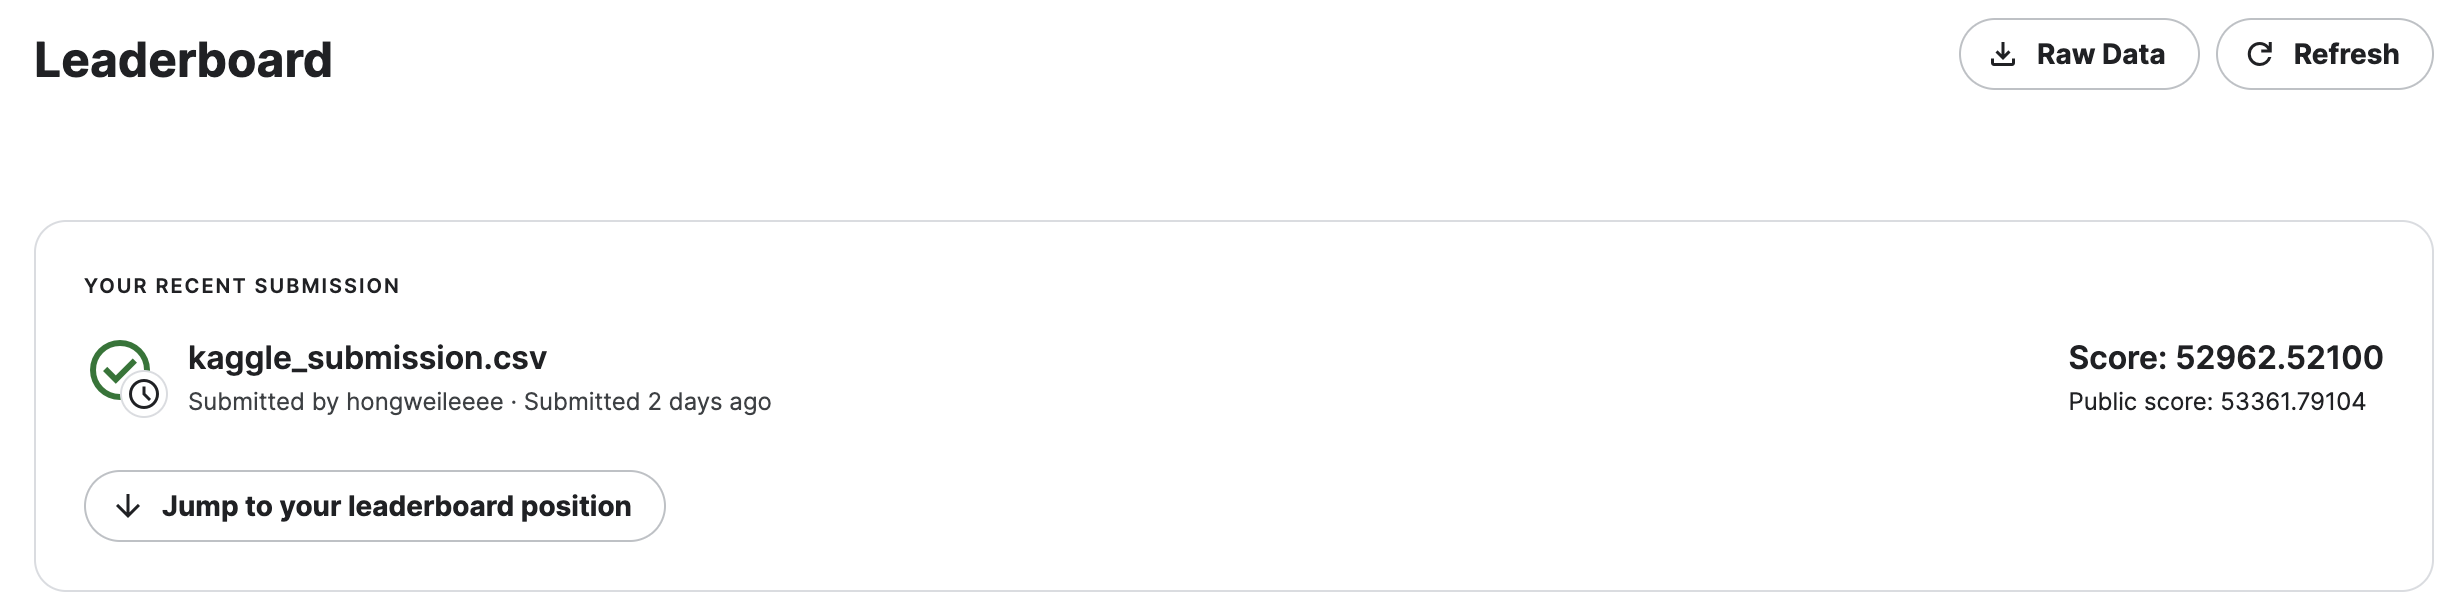